In [ ]:
# AMPL - algebraic modeling programming language
# Airline Seat Allocation
# 3 classes: first class, business class, economy class
# 3 scenarios: morning and evening, weekend, midday

In [27]:
# install dependencies and select solver
%pip install -q amplpy pandas matplotlib numpy scipy

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://ampl.com/colab).


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# scenario data
demand = pd.DataFrame(
    {
        "morning and evening": {"F": 20, "B": 50, "E": 200},
        "weekend": {"F": 10, "B": 24, "E": 175},
        "midday": {"F": 6, "B": 10, "E": 150},
    }
).T

# global revenue and seat factor data
capacity = 200
revenue_factor = pd.Series({"F": 3.0, "B": 2.0, "E": 1.0})
seat_factor = pd.Series({"F": 2.0, "B": 1.5, "E": 1.0})


Seat Allocation


,F,B,E,TOTAL
seat allocation,0.0,0.0,200.0,200.0
economy equivalent seat allocation,0.0,0.0,200.0,200.0



Tickets Sold


,F,B,E
morning and evening,0,0,200
weekend,0,0,175
midday,0,0,150



Seats not Sold


,F,B,E
morning and evening,0,0,0
weekend,0,0,25
midday,0,0,50



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,20,50,0
weekend,10,24,0
midday,6,10,0



Expected Revenue (in units of economy ticket price): 175.00


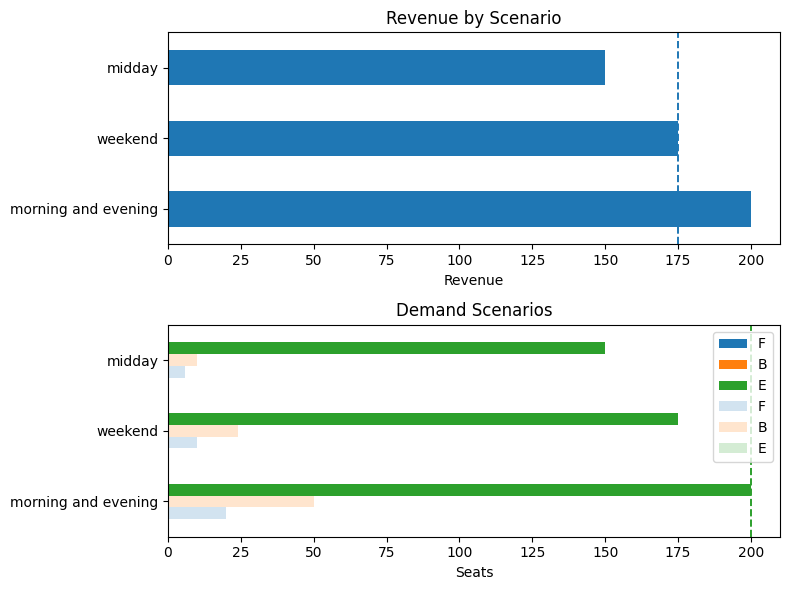

In [30]:
# function to report analytics for any given seat allocations
def seat_report(seats, demand):
    classes = seats.index

    # report seat allocation
    equivalent_seats = pd.DataFrame(
        {
            "seat allocation": {c: seats[c] for c in classes},
            "economy equivalent seat allocation": {
                c: seats[c] * seat_factor[c] for c in classes
            },
        }
    ).T
    equivalent_seats["TOTAL"] = equivalent_seats.sum(axis=1)
    print("\nSeat Allocation")
    display(equivalent_seats)

    # tickets sold is the minimum of available seats and demand
    tickets = pd.DataFrame()
    for c in classes:
        tickets[c] = np.minimum(seats[c], demand[c])
    print("\nTickets Sold")
    display(tickets)

    # seats unsold
    unsold = pd.DataFrame()
    for c in classes:
        unsold[c] = seats[c] - tickets[c]
    print("\nSeats not Sold")
    display(unsold)

    # spillage (unmet demand)
    spillage = demand - tickets
    print("\nSpillage (Unfulfilled Demand)")
    display(spillage)

    # compute revenue
    revenue = tickets.dot(revenue_factor)
    print(
        f"\nExpected Revenue (in units of economy ticket price): {revenue.mean():.2f}"
    )

    # charts
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    revenue.plot(ax=ax[0], kind="barh", title="Revenue by Scenario")
    ax[0].plot([revenue.mean()] * 2, ax[0].get_ylim(), "--", lw=1.4)
    ax[0].set_xlabel("Revenue")

    tickets[classes].plot(
        ax=ax[1], kind="barh", rot=0, stacked=False, title="Demand Scenarios"
    )
    demand[classes].plot(
        ax=ax[1],
        kind="barh",
        rot=0,
        stacked=False,
        title="Demand Scenarios",
        alpha=0.2,
    )
    for c in classes:
        ax[1].plot([seats[c]] * 2, ax[1].get_ylim(), "--", lw=1.4)
    ax[1].set_xlabel("Seats")
    fig.tight_layout()

    return


# a trial solution
seats_all_economy = pd.Series({"F": 0, "B": 0, "E": 200})
seat_report(seats_all_economy, demand)

In [31]:
%%writefile airline_deterministic.mod

param capacity;

set CLASSES;

param seat_factor{CLASSES};
param demand{CLASSES};
param revenue_factor{CLASSES};

# first stage variables and constraints
var seats{CLASSES} integer >= 0;

s.t. plane_seats: sum{c in CLASSES}(seats[c] * seat_factor[c]) <= capacity;

# second stage variable and constraints
var tickets{CLASSES} integer >= 0;

s.t. demand_limits {c in CLASSES}: tickets[c] <= demand[c];
s.t. seat_limits {c in CLASSES}: tickets[c] <= seats[c];

# objective
maximize revenue: sum{c in CLASSES}(tickets[c] * revenue_factor[c]);

Writing airline_deterministic.mod


HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 226
2 simplex iterations
1 branching nodes

Seat Allocation


,F,B,E,TOTAL
seat allocation,12.0,28.0,134.0,174.0
economy equivalent seat allocation,24.0,42.0,134.0,200.0



Tickets Sold


,F,B,E
morning and evening,12,28,134
weekend,10,24,134
midday,6,10,134



Seats not Sold


,F,B,E
morning and evening,0,0,0
weekend,2,4,0
midday,6,18,0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,8,22,66
weekend,0,0,41
midday,0,0,16



Expected Revenue (in units of economy ticket price): 203.33


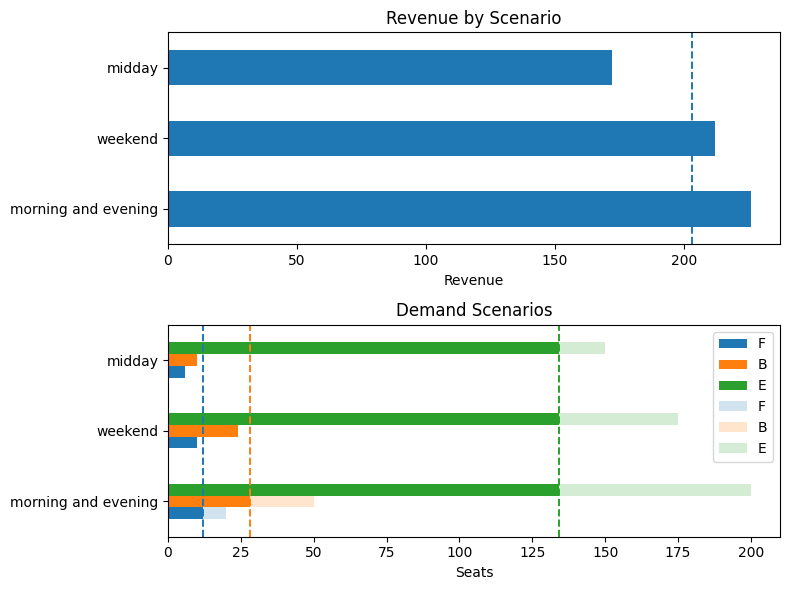

In [32]:
def airline_deterministic(demand):
    # Create AMPL instance and load the model
    ampl = AMPL()
    ampl.read("airline_deterministic.mod")

    # load the data
    ampl.set["CLASSES"] = demand.columns.tolist()
    ampl.param["demand"] = demand.mean()
    ampl.param["revenue_factor"] = revenue_factor
    ampl.param["seat_factor"] = seat_factor
    ampl.param["capacity"] = capacity
    return ampl


# Solve a given model and return a Pandas series of the seats for each class
def airline_solve(model):
    model.solve(solver=SOLVER)
    assert model.solve_result == "solved", model.solve_result
    return pd.Series(model.var["seats"].to_dict()).reindex(index=["F", "B", "E"])


# Solve deterministic model to obtain the expectation of the expected value problem (EEV)
model_eev = airline_deterministic(demand)
seats_eev = airline_solve(model_eev)
seat_report(seats_eev, demand)

In [33]:
%%writefile airline_stochastic.mod

param capacity;

set CLASSES;
set SCENARIOS;

param demand{CLASSES, SCENARIOS};
param seat_factor{CLASSES};
param revenue_factor{CLASSES};

# first stage variables and constraints
var seats{CLASSES} integer >= 0;

s.t. plane_seats: sum{c in CLASSES}(seats[c] * seat_factor[c]) <= capacity;

# second stage variable and constraints
var tickets{CLASSES, SCENARIOS} integer >= 0;

s.t. demand_limits {c in CLASSES, s in SCENARIOS}: tickets[c, s] <= demand[c, s];
s.t. seat_limits {c in CLASSES, s in SCENARIOS}: tickets[c, s] <= seats[c];

# objective
maximize revenue: sum{c in CLASSES, s in SCENARIOS}(tickets[c, s] * revenue_factor[c]);

Writing airline_stochastic.mod


HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 628
7 simplex iterations
1 branching nodes

Seat Allocation


,F,B,E,TOTAL
seat allocation,10.0,20.0,150.0,180.0
economy equivalent seat allocation,20.0,30.0,150.0,200.0



Tickets Sold


,F,B,E
morning and evening,10,20,150
weekend,10,20,150
midday,6,10,150



Seats not Sold


,F,B,E
morning and evening,0,0,0
weekend,0,0,0
midday,4,10,0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,10,30,50
weekend,0,4,25
midday,0,0,0



Expected Revenue (in units of economy ticket price): 209.33


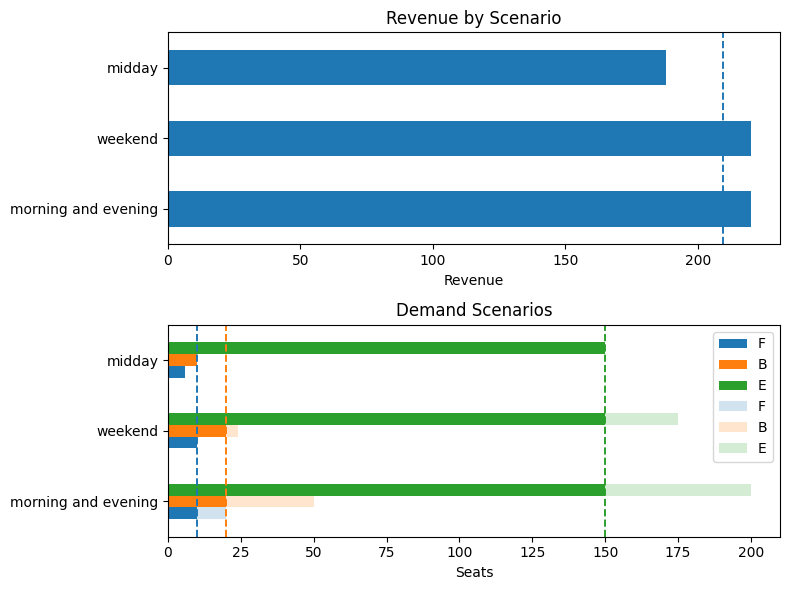

In [34]:
def airline_stochastic(demand):
    # Create AMPL instance and load the model
    ampl = AMPL()
    ampl.read("airline_stochastic.mod")

    # load the data
    ampl.set["CLASSES"] = demand.columns.tolist()
    ampl.set["SCENARIOS"] = demand.index.values.tolist()
    ampl.param["demand"] = demand.T
    ampl.param["revenue_factor"] = revenue_factor
    ampl.param["seat_factor"] = seat_factor
    ampl.param["capacity"] = capacity

    return ampl


# create and solve model for the three scenarios defined above
model_stochastic = airline_stochastic(demand)
seats_stochastic = airline_solve(model_stochastic)
seat_report(seats_stochastic, demand)

,mu,sigma
F,12.0,4
B,28.0,16
E,175.0,20


subject to first_class: seats['F'] - 12 >= 8.21499564252729;
subject to business_class: seats['F'] + seats['B'] - 40 >=
  27.127620970404912;
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 531
4 simplex iterations
1 branching nodes

Seat Allocation


,F,B,E,TOTAL
seat allocation,21.0,47.0,87.0,155.0
economy equivalent seat allocation,42.0,70.5,87.0,199.5



Tickets Sold


,F,B,E
morning and evening,20,47,87
weekend,10,24,87
midday,6,10,87



Seats not Sold


,F,B,E
morning and evening,1,0,0
weekend,11,23,0
midday,15,37,0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,0,3,113
weekend,0,0,88
midday,0,0,63



Expected Revenue (in units of economy ticket price): 177.00


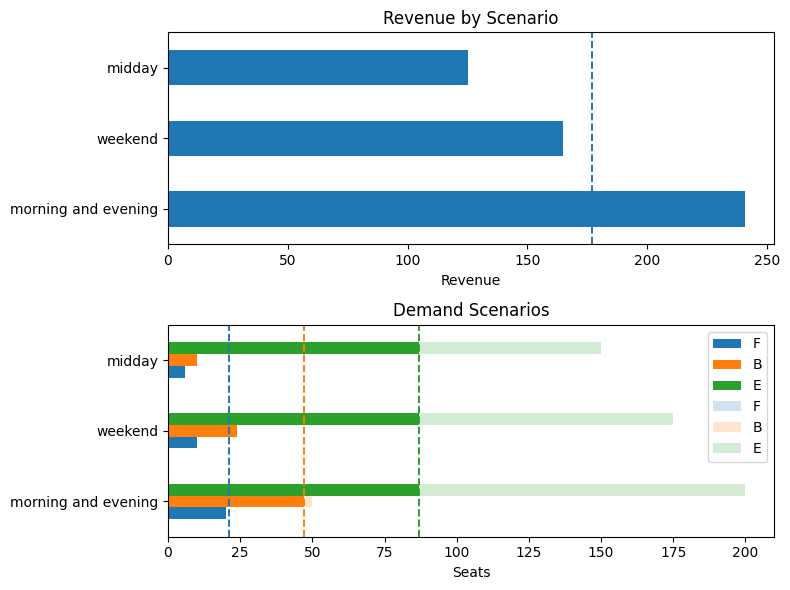

In [35]:
# import the scipy.stats.norm object needed to use the quantile function of the standard normal distribution
from scipy.stats import norm

# define the mean and standard deviation of the demand for each class
mu = demand.mean()
sigma = {"F": 4, "B": 16, "E": 20}
display(pd.DataFrame({"mu": mu, "sigma": sigma}))


# create a new model with chance constraints that takes as input also
# the target quality of service (QoS) levels for classes F and B
def airline_cc(demand, QoSF=0.98, QoSFB=0.95):
    # create two-stage stochastic model as before
    m = airline_stochastic(demand)

    # add equivalent counterparts of the two chance constraints to the first stage problem
    # the two coefficients related the inverse CDF of the standard normal are computed using the norm.ppf function

    first_class = "s.t. first_class: seats['F'] - {} >= {};".format(
        mu["F"], norm.ppf(QoSF) * sigma["F"]
    )
    m.eval(first_class)
    business_class = "s.t. business_class: seats['F'] + seats['B'] - {} >= {};".format(
        mu["F"] + mu["B"], norm.ppf(QoSFB) * np.sqrt(sigma["F"] ** 2 + sigma["B"] ** 2)
    )
    m.eval(business_class)
    print(m.con["first_class"])
    print(m.con["business_class"])

    return m


# create and solve model
model_cc = airline_cc(demand)
seats_cc = airline_solve(model_cc)
seat_report(seats_cc, demand)


Model Covariance


,F,B,E
F,16,0,0
B,0,256,0
E,0,0,400


,mu (mean),sample mean,sigma (std),sample std
F,12.0,11.889,4,4.088936
B,28.0,28.626,16,15.051534
E,175.0,172.966,20,19.839669


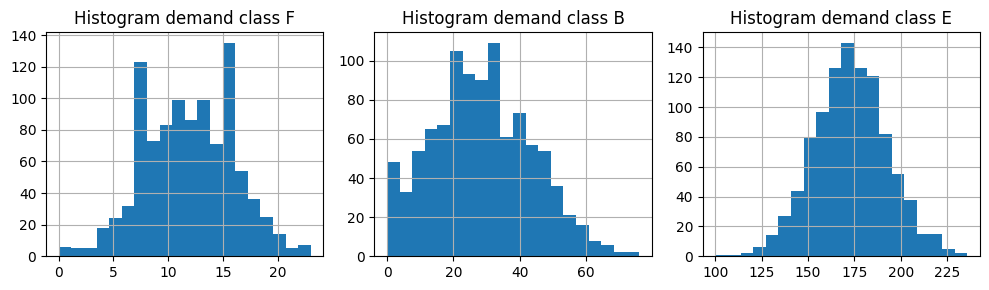

In [36]:
# sample size
N = 1000

# define the mean mu and standard deviation sigma of the demand for each class
mu = demand.mean()
sigma = {"F": 4, "B": 16, "E": 20}
classes = demand.columns

# build covariance matrix from covariances and correlations
s = np.array(list(sigma.values()))
S = np.diag(s) @ np.diag(s)
print("\nModel Covariance")
df = pd.DataFrame(S, index=classes, columns=classes)
display(df)

# generate N samples, round each demand entry to nearest integer, and correct non-negative values
seed = 0
rng = np.random.default_rng(seed)
samples = rng.multivariate_normal(list(mu), S, N).round()
demand_saa = pd.DataFrame(samples, columns=classes)
demand_saa[demand_saa < 0] = 0

# report sample means and standard deviations for each class
demand_saa_stats = pd.DataFrame(
    {
        "mu (mean)": mu,
        "sample mean": demand_saa.mean(),
        "sigma (std)": sigma,
        "sample std": demand_saa.std(),
    }
)
display(demand_saa_stats)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, ci in enumerate(classes):
    demand_saa[ci].hist(ax=ax[i], bins=20)
    ax[i].set_title(f"Histogram demand class {ci}")
fig.tight_layout()

In [37]:
# function to report analytics for SAA case
def seat_report_saa(seats, demand):
    classes = seats.index

    # report seat allocation
    equivalent_seats = pd.DataFrame(
        {
            "seat allocation": {c: seats[c] for c in classes},
            "economy equivalent seat allocation": {
                c: seats[c] * seat_factor[c] for c in classes
            },
        }
    ).T
    equivalent_seats["TOTAL"] = equivalent_seats.sum(axis=1)
    print("\nSeat Allocation")
    display(equivalent_seats)

    # tickets sold
    tickets = pd.DataFrame()
    for c in classes:
        tickets[c] = np.minimum(seats[c], demand[c])

    print("\nMean Tickets Sold")
    display(tickets.mean())

    # seats unsold
    unsold = pd.DataFrame()
    for c in classes:
        unsold[c] = seats[c] - tickets[c]
    print("\nMean Seats not Sold")
    display(unsold.mean())

    # spillage (unmet demand)
    spillage = demand - tickets
    print("\nMean Spillage (Unfulfilled Demand)")
    display(spillage.mean())

    # compute revenue
    revenue = tickets.dot(revenue_factor)
    print(
        f"\nExpected Revenue (in units of economy ticket price): {revenue.mean():.2f}"
    )

    # charts
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    revenue.hist(ax=ax, bins=20)
    ax.set_title("Revenue Histogram")

    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    for i, c in enumerate(classes):
        tickets[c].hist(ax=ax[i], bins=20, alpha=0.4)
        demand[c].hist(ax=ax[i], alpha=0.4)
        ax[i].legend(["Tickets Sold", "Demand"])
        ax[i].set_xlim(0, 300)

    fig.tight_layout()
    return

HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 211180
2082 simplex iterations
1 branching nodes

Seat Allocation


,F,B,E,TOTAL
seat allocation,11.0,20.0,148.0,179.0
economy equivalent seat allocation,22.0,30.0,148.0,200.0



Mean Tickets Sold


,0
F,9.764
B,17.416
E,147.056



Mean Seats not Sold


,0
F,1.236
B,2.584
E,0.944



Mean Spillage (Unfulfilled Demand)


,0
F,2.125
B,11.210
E,25.910



Expected Revenue (in units of economy ticket price): 211.18


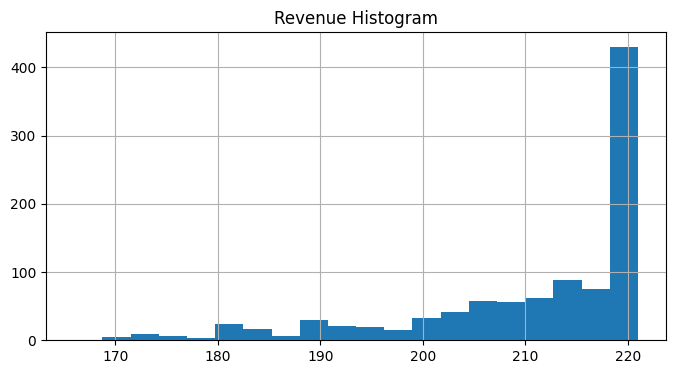

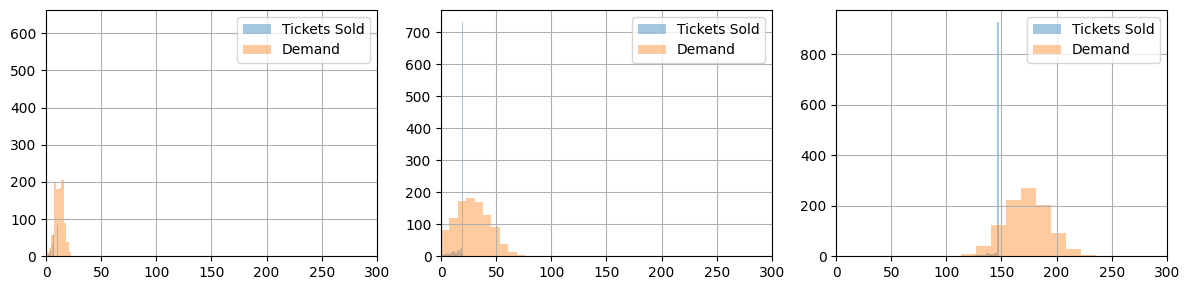

In [38]:
model_ssa = airline_stochastic(demand_saa)
seats_saa = airline_solve(model_ssa)
seat_report_saa(seats_saa, demand_saa)

,mu,sigma
F,12.0,4
B,28.0,16
E,175.0,20


,mu,sample means
F,12.0,12.012
B,28.0,28.590
E,175.0,175.301


,sigma,sample std dev
F,4,3.951388
B,16,15.139984
E,20,20.147365



Model Covariance


,F,B,E
F,16.0,38.4,16.0
B,38.4,256.0,128.0
E,16.0,128.0,400.0



Sample Covariance


,F,B,E
F,15.613469,36.044965,12.434823
B,36.044965,229.219119,107.216627
E,12.434823,107.216627,405.916315


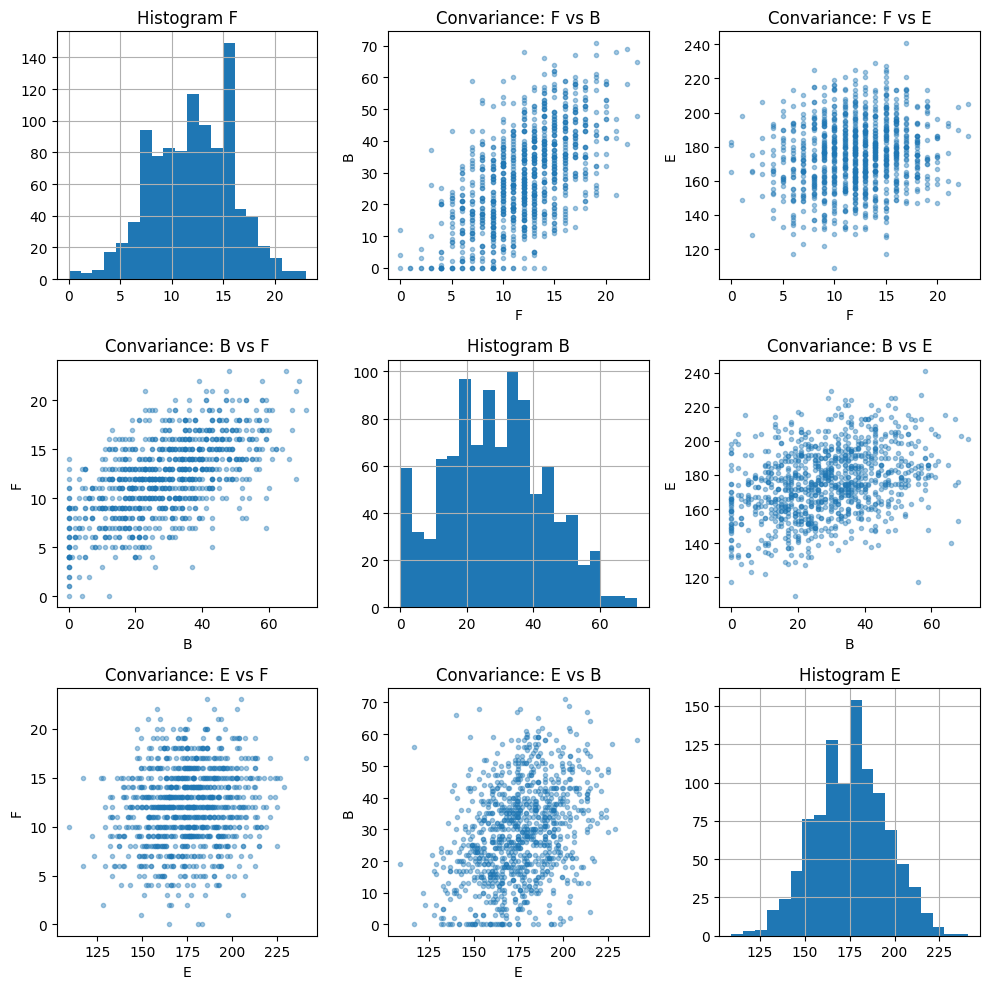

In [39]:
# sample size
N = 1000

# define the mean mu and standard deviation sigma of the demand for each class
mu = demand.mean()
sigma = {"F": 4, "B": 16, "E": 20}
display(pd.DataFrame({"mu": mu, "sigma": sigma}))

# correlation matrix
P = np.array([[1, 0.6, 0.2], [0.6, 1, 0.4], [0.2, 0.4, 1]])

# build covariance matrix from covariances and correlations
s = np.array(list(sigma.values()))
S = np.diag(s) @ P @ np.diag(s)

# create samples
np.random.seed(1)
samples = np.random.multivariate_normal(list(mu), S, N).round()

# truncate to integers and non-negative values
classes = demand.columns
demand_saa = pd.DataFrame(samples, columns=classes)
demand_saa[demand_saa < 0] = 0

df = pd.DataFrame(mu, columns=["mu"])
df["sample means"] = demand_saa.mean()
display(df)

df = pd.DataFrame(pd.Series(sigma), columns=["sigma"])
df["sample std dev"] = demand_saa.std()
display(df)

print("\nModel Covariance")
df = pd.DataFrame(S, index=classes, columns=classes)
display(df)

print("\nSample Covariance")
display(pd.DataFrame(demand_saa.cov()))

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i, ci in enumerate(classes):
    for j, cj in enumerate(classes):
        if i == j:
            demand_saa[ci].hist(ax=ax[i, i], bins=20)
            ax[i, i].set_title(f"Histogram {ci}")
        else:
            ax[i, j].plot(demand_saa[ci], demand_saa[cj], ".", alpha=0.4)
            ax[i, j].set_xlabel(ci)
            ax[i, j].set_ylabel(cj)
            ax[i, j].set_title(f"Convariance: {ci} vs {cj}")
fig.tight_layout()

In [40]:
%%writefile airline_final.mod

param capacity;

set CLASSES;
set SCENARIOS;

param nSCENARIOS := card(SCENARIOS);
param bigM;

param demand{CLASSES, SCENARIOS};
param seat_factor{CLASSES};
param revenue_factor{CLASSES};

param first_class_id symbolic;
param business_class_id symbolic;

param first_class_demand_cover_prop;
param business_class_demand_cover_prop;

# first stage variables and constraints
var seats{CLASSES} integer >= 0;

s.t. plane_seats: sum{c in CLASSES}(seats[c] * seat_factor[c]) <= capacity;

# second stage variable and constraints
var tickets{CLASSES, SCENARIOS} integer >= 0;
var first_class {SCENARIOS} binary;
var business_class {SCENARIOS} binary;

s.t. demand_limits {c in CLASSES, s in SCENARIOS}: tickets[c, s] <= demand[c, s];
s.t. seat_limits {c in CLASSES, s in SCENARIOS}: tickets[c, s] <= seats[c];

s.t. first_class_loyality {s in SCENARIOS}:
    seats[first_class_id] + bigM * first_class[s] >= demand[first_class_id, s];
s.t. first_class_loyality_rate:
    sum{s in SCENARIOS} first_class[s] <= (1 - first_class_demand_cover_prop) * nSCENARIOS;
s.t. business_class_loyality {s in SCENARIOS}:
    seats[first_class_id] + seats[business_class_id] + bigM * business_class[s] >=
        demand[business_class_id, s] + demand[first_class_id, s];
s.t. business_class_loyality_rate:
    sum{s in SCENARIOS} business_class[s] <= (1 - business_class_demand_cover_prop) * nSCENARIOS;

# objective
maximize revenue: sum{c in CLASSES, s in SCENARIOS}(tickets[c, s] * revenue_factor[c]);

Writing airline_final.mod


HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 177047
51622 simplex iterations
3 branching nodes

Seat Allocation


,F,B,E,TOTAL
seat allocation,20.0,50.0,85.0,155.0
economy equivalent seat allocation,40.0,75.0,85.0,200.0



Mean Tickets Sold


,0
F,11.995
B,28.031
E,85.000



Mean Seats not Sold


,0
F,8.005
B,21.969
E,0.000



Mean Spillage (Unfulfilled Demand)


,0
F,0.017
B,0.559
E,90.301



Expected Revenue (in units of economy ticket price): 177.05


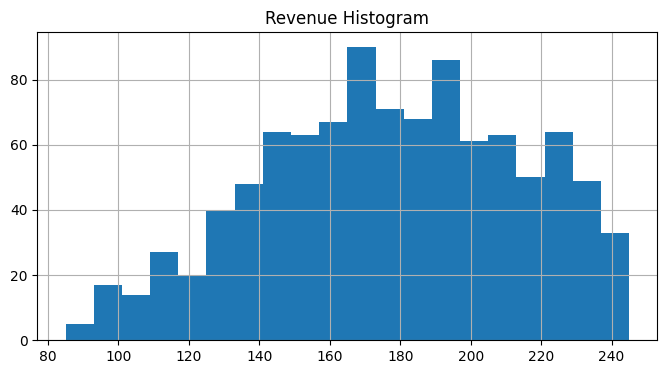

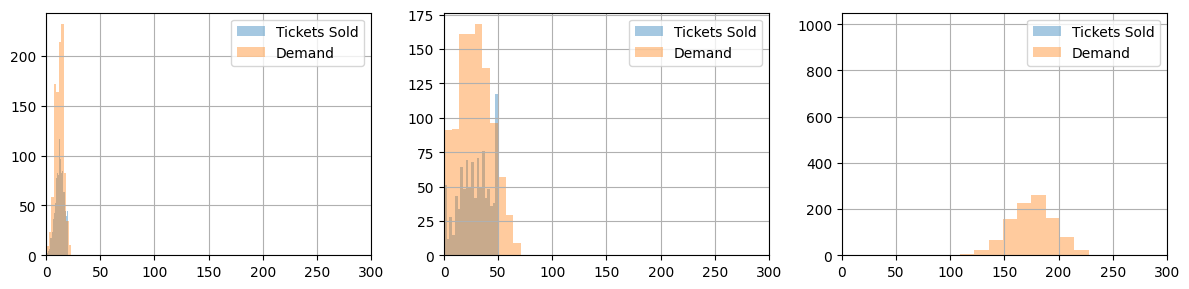

In [41]:
# define big M constant for chance constraints counterparts
bigM = 100


def airline_final(demand):
    # Create AMPL instance and load the model
    ampl = AMPL()
    ampl.read("airline_final.mod")

    # load the data
    ampl.set["CLASSES"] = demand.columns.tolist()
    ampl.set["SCENARIOS"] = demand.index.values.tolist()
    ampl.param["demand"] = demand.T
    ampl.param["revenue_factor"] = revenue_factor
    ampl.param["seat_factor"] = seat_factor
    ampl.param["capacity"] = capacity
    ampl.param["bigM"] = bigM
    ampl.param["first_class_id"] = "F"
    ampl.param["business_class_id"] = "B"
    ampl.param["first_class_demand_cover_prop"] = 0.98
    ampl.param["business_class_demand_cover_prop"] = 0.95
    return ampl


# create model
model = airline_final(demand_saa)
seats = airline_solve(model)
seat_report_saa(seats, demand_saa)

In [ ]:
# https://ampl.com/mo-book/notebooks/10/airline-seating.html